In [1]:
import h5py
import logging

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

import sys

sys.path.insert(0, "../scripts")

from swe_2d import ShallowTwo, ShallowTwoFilter
from statfenics.utils import build_observation_operator

logging.basicConfig(level=logging.INFO)
fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
# physical settings
period = 120.
nu = 1e-6
g = 9.8

# reference values
u_ref = 0.01  # cm/s
length_ref = 0.1  # cylinder
time_ref = length_ref / u_ref
H_ref = length_ref

# compute reynolds number
Re = u_ref * length_ref / nu

params = dict(
    nu=1 / Re,
    g=g * length_ref / u_ref**2,
    C=0.,
    H=0.053 / H_ref,
    u_inflow=0.004 / u_ref,
    inflow_period=period / time_ref)
control = dict(
    dt=5e-2,
    theta=0.5,
    simulation="laminar",
    use_imex=False,
    use_les=False)

mesh = "../mesh/branson-mesh-nondim.xdmf"
swe = ShallowTwoFilter(mesh, params, control, comm=fe.MPI.comm_world)

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe.setup_form()
swe.setup_solver()

INFO:swe_2d:reading mesh from file
INFO:swe_2d:mesh has 30914 elements
INFO:swe_2d:dx(max) = 0.16463, dx(min): 0.01647
INFO:swe_2d:CFL number is 1.214464
INFO:swe_2d:using mumps solver with default PC


In [3]:
# setup filter (basically compute prior additive noise covariance)
rho = 1e-3
ell = 2.
k = 32
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=0.,
                   ell_u=ell, ell_v=ell, ell_h=ell,
                   k_init_u=k, k_init_v=k, k_init_h=0, k=100)
swe.setup_filter(stat_params)

INFO:swe_2d:Eigenvalues converged: 34
INFO:swe_2d:Laplacian eigenvalues: [0.49538112 0.49889808 0.79504997 0.81095127 1.28545657 1.32998194
 1.65461323 1.67887616 1.88845461 1.94320277 1.97801673 2.05393685
 2.29468523 2.47632819 2.70765522 2.88391652 2.97782881 3.17342028
 3.49155374 3.65499824 3.66197973 3.6800605  3.94880231 4.00222481
 4.06871887 4.10525462 4.41544561 4.4850333  4.63129883 4.69640502
 5.1545045  5.16134018]
INFO:swe_2d:Spectral diff (u): 8.2634e-10, 9.3316e-06
INFO:swe_2d:Eigenvalues converged: 34
INFO:swe_2d:Laplacian eigenvalues: [0.49538112 0.49889808 0.79504997 0.81095127 1.28545657 1.32998194
 1.65461323 1.67887616 1.88845461 1.94320277 1.97801673 2.05393685
 2.29468523 2.47632819 2.70765522 2.88391652 2.97782881 3.17342028
 3.49155374 3.65499824 3.66197973 3.6800605  3.94880231 4.00222481
 4.06871887 4.10525462 4.41544561 4.4850333  4.63129883 4.69640502
 5.1545045  5.16134018]
INFO:swe_2d:Spectral diff (v): 8.2634e-10, 9.3316e-06


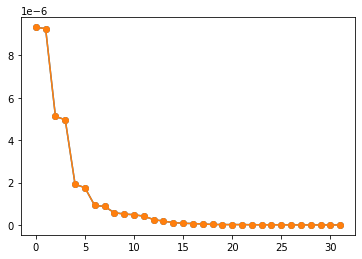

In [4]:
plt.plot(swe.Ku_vals, "o-")
plt.plot(swe.Kv_vals, "o-")
plt.show()

In [6]:
t = 0.
t_final = 0.25 * period / time_ref
nt = np.int32(np.round(t_final / control["dt"]))

means = np.zeros((nt, swe.mean.shape[0]))
variances = np.zeros((nt, swe.mean.shape[0]))
eff_ranks = np.zeros((nt, ))

i_dat = 0
for i in trange(nt):
    t += swe.dt
    swe.inlet_velocity.t = t
    swe.prediction_step(t)
    
    means[i, :] = swe.mean.copy()
    variances[i, :] = np.sum(swe.cov_sqrt**2, axis=1)
    eff_ranks[i] = swe.eff_rank
    logging.info('Effective rank: %.5f', swe.eff_rank)
    
    swe.set_prev()

  0%|                                                                                                                    | 0/60 [00:00<?, ?it/s]INFO:swe_2d:Prop. variance kept in reduction: 1.00000
INFO:root:Effective rank: 21.76856
  2%|█▊                                                                                                          | 1/60 [00:14<14:06, 14.35s/it]INFO:swe_2d:Prop. variance kept in reduction: 0.99996
INFO:root:Effective rank: 32.85593
  3%|███▌                                                                                                        | 2/60 [00:29<14:04, 14.56s/it]INFO:swe_2d:Prop. variance kept in reduction: 0.99962
INFO:root:Effective rank: 35.57129
  5%|█████▍                                                                                                      | 3/60 [00:43<13:54, 14.64s/it]INFO:swe_2d:Prop. variance kept in reduction: 0.99951
INFO:root:Effective rank: 37.27753
  7%|███████▏                                                       

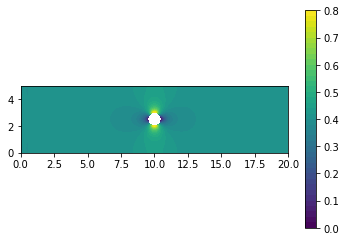

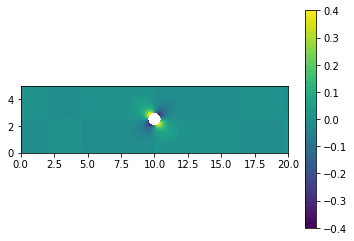

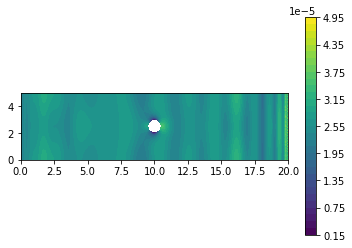

In [7]:
vel, h = swe.du.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

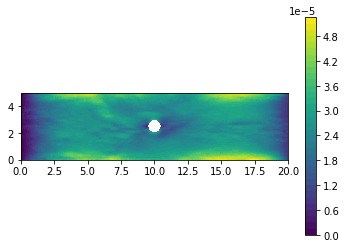

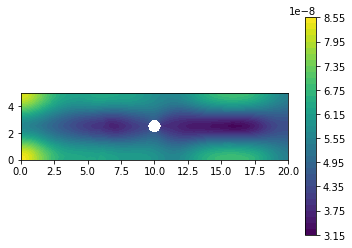

In [10]:
var_v = np.sqrt(np.sum(swe.cov_sqrt**2, axis=1))
var_f = fe.Function(swe.W)
var_f.vector().set_local(var_v)

vel, h = var_f.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

In [9]:
t += swe.dt
%load_ext line_profiler
%lprun -f swe.prediction_step swe.prediction_step(t)
swe.set_prev()

INFO:swe_2d:Prop. variance kept in reduction: 0.99785


Timer unit: 1e-06 s

Total time: 15.406 s
File: /home/connor/Projects/20220609-swfe/docs/../scripts/swe_2d.py
Function: prediction_step at line 630

Line #      Hits         Time  Per Hit   % Time  Line Contents
   630                                               def prediction_step(self, t):
   631         1    1915219.0 1915219.0     12.4          self.solve()
   632         1        785.0    785.0      0.0          self.mean[:] = self.du.vector().get_local()
   633                                           
   634                                                   # TODO(connor): reuse sparsity patterns?
   635         1    1018496.0 1018496.0      6.6          self.assemble_derivatives()
   636         1    5402785.0 5402785.0     35.1          self.J_scipy_lu = splu(self.J_scipy.tocsc())  # options=dict(Fact="SamePattern")
   637                                           
   638         1     219118.0 219118.0      1.4          self.cov_sqrt_pred[:, :self.k] = self.J_prev_scipy @ 